In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from torch.utils.data import DataLoader
import numpy as np
from dataloader import SaliconCoCoDataset

In [3]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 8]

In [4]:
dataset_folder = "../data/"
txt_path = "./dataset/train_list.txt"
img_list = np.loadtxt(txt_path, dtype=str)
dataset = SaliconCoCoDataset(dataset_folder, img_list)

BATCH_SIZE = 2
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

a = iter(train_loader).next()
print(a['image'].dtype, a['saliency'].dtype, a['mask'].dtype)
print(a['image'].shape, a['saliency'].shape, a['mask'].shape)

    

torch.float32 torch.float32 torch.float32
torch.Size([2, 3, 256, 256]) torch.Size([2, 1, 256, 256]) torch.Size([2, 1, 256, 256])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 255.5, 255.5, -0.5)

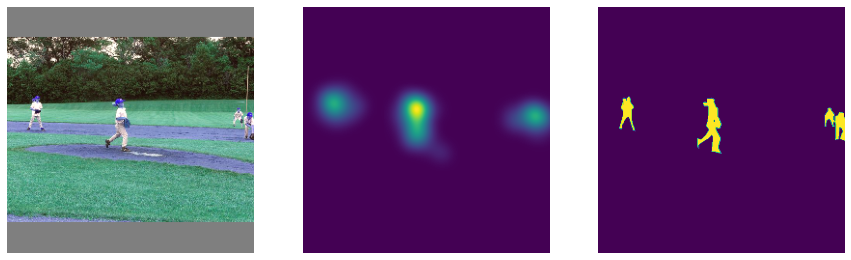

In [5]:
plt.subplot(1,3,1)
plt.imshow(a['image'][0].permute((1,2,0)).numpy()[:,:,::-1]*0.225+0.5)
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(a['saliency'][0].permute((1,2,0)).numpy())
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(a['mask'][0].permute((1,2,0)).numpy())
plt.axis('off')

In [6]:
import torch

In [7]:
from model.net import SSNet
from model.loss import loss_sal

/usr/local/lib/python3.8/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [8]:
model = SSNet(3)

# model_dir = '../basnet_pretrained.pth'
model_dir = '../weights/SSNET_init.pth'
model.load_state_dict(torch.load(model_dir), strict=False)

for name, param in model.named_parameters():
    if "_sal" not in name:
        param.requires_grad = False


In [9]:
# # save weight
# model_dir = "../weights/"
# torch.save(model.state_dict(), model_dir + "SSNET_init.pth")


In [10]:
_ = model(a['image'], segmentation=True)

/usr/local/lib/python3.8/site-packages/torch/nn/functional.py:3060: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "


In [11]:
seg_out, sal_out = model(a['image'], segmentation=False)

In [28]:
from model.loss import multi_seg_loss_fusion
from model.loss import multi_bce_loss_fusion

/usr/local/lib/python3.8/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [31]:
last_sal_loss, sum_sal_loss = multi_bce_loss_fusion(sal_out[0], sal_out[1],sal_out[2],sal_out[3],sal_out[4],sal_out[5],sal_out[6], a['saliency'])
print(last_sal_loss, sum_sal_loss)

tensor(2.7762, grad_fn=<AddBackward0>) tensor(18.4224, grad_fn=<AddBackward0>)


In [12]:
for i in range(len(sal_out)):
    loss = loss_sal(sal_out[i].squeeze(), a['saliency'].squeeze())
    print(loss)

tensor(1.5502, grad_fn=<AddBackward0>)
tensor(1.4157, grad_fn=<AddBackward0>)
tensor(1.5293, grad_fn=<AddBackward0>)
tensor(1.4211, grad_fn=<AddBackward0>)
tensor(1.3384, grad_fn=<AddBackward0>)
tensor(1.2873, grad_fn=<AddBackward0>)
tensor(1.3692, grad_fn=<AddBackward0>)


In [13]:
loss.backward()